In [7]:
:extension NoMonomorphismRestriction FlexibleContexts TypeFamilies
import Control.Monad
import Control.Monad.State

import System.Random
import Data.Random
import Data.Random.Distribution.Pareto
import Data.RVar

import Diagrams.Prelude hiding (normal)
import Data.Colour.Palette.BrewerSet
import qualified Diagrams.Color.XKCD as XKCD
import Data.Colour (withOpacity)

In [42]:
randomNormal :: (Distribution Normal a, Num a) => RVar a
randomNormal = normal 0 1

sampleNormal :: State StdGen Double
sampleNormal = sampleRVar randomNormal

evalState sampleNormal $ mkStdGen 1

-1.139167836612823

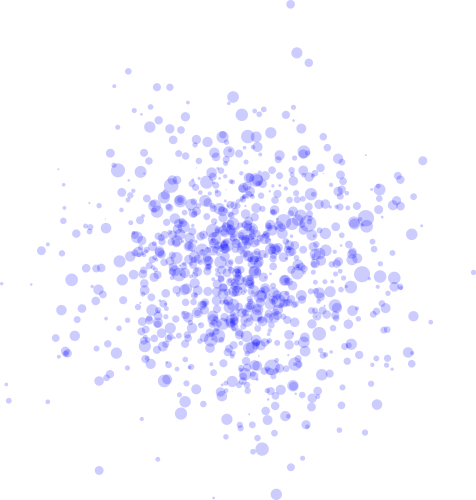

In [40]:
bubble r = circle r # lw none # fcA (blue `withOpacity` 0.2)

-- RVarT Identity b
randBubbles n = do
  rs <- replicateM n $ normal 1 0.4
  xs <- replicateM n $ normal 0 20
  ys <- replicateM n $ normal 0 20
  let points = map p2 $ zip xs ys
      spots  = map bubble rs
  return $ position (zip points spots)
          
-- (MonadRandom m, ...) m a
sampleBubbles n = sampleRVar $ randBubbles n

withImgHeight 500 $ diagram $ evalState (sampleBubbles 1000) $ mkStdGen 1

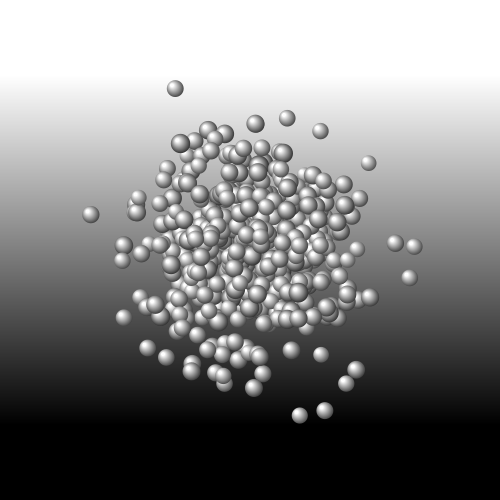

In [56]:
radial = mkRadialGradient (mkStops [(white,0,1), (black,1,1)])
                          ((-0.15) ^& (0.15)) 0.06 (0 ^& 0) 0.5
                          GradPad

linear = mkLinearGradient (mkStops [(black,0,1), (white,1,1)])
                          (0 ^& (-7)) (0 ^& 7)
                          GradPad
                          
bubble r = circle r # fillTexture radial # lw none

-- RVarT Identity b
randBubbles n = do
  rs <- replicateM n $ normal 0.35 0.02
  xs <- replicateM n $ normal 0 2
  ys <- replicateM n $ normal 0 2
  let points = map p2 $ zip xs ys
      spots  = map bubble rs
  return $ position (zip points spots)
          
-- (MonadRandom m, ...) m a
sampleBubbles n = sampleRVar $ randBubbles n

diagramBubbles n = evalState (sampleBubbles n) $ mkStdGen 1

withImgHeight 500 $ diagram $ diagramBubbles 500 <> rect 20 20 # fillTexture linear # lw none